In [1]:
%load_ext autoreload
%autoreload 2   

In [2]:
%matplotlib inline


In [3]:
# download channel maps for probes
from kilosort.utils import download_probes

download_probes()

In [4]:
from kilosort import run_kilosort, DEFAULT_SETTINGS


data_dir = "/home/anirudh/spike_sorting/SGL_DATA/test-day1- spine-bellyneuron_g1/test-day1- spine-bellyneuron_g1_imec0/"
trial_name = data_dir.split(" ")[-2].split("/")[0].split("-")[-1]
settings = DEFAULT_SETTINGS
settings["data_dir"] = data_dir
settings["n_chan_bin"] = 385

ops, st, clu, tF, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes = (
    run_kilosort(
        settings=settings,
        probe_name="neuropixPhase3B1_kilosortChanMap.mat",
        results_dir=f"{trial_name}_kilosort4",
    )
)

kilosort.run_kilosort: Kilosort version 4.0.17
kilosort.run_kilosort: Sorting /home/anirudh/spike_sorting/SGL_DATA/test-day1- spine-bellyneuron_g1/test-day1- spine-bellyneuron_g1_imec0/test-day1- spine-bellyneuron_g1_t0.imec0.ap.bin
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.


kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: N samples: 1675089
kilosort.run_kilosort: N seconds: 55.8363
kilosort.run_kilosort: N batches: 28
kilosort.run_kilosort: Preprocessing filters computed in  0.82s; total  0.83s
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.spikedetect: Re-computing universal templates from data.
100%|██████████| 28/28 [00:08<00:00,  3.16it/s]
kilosort.run_kilosort: drift computed in  9.75s; total  10.58s
kilosort.run_kilosort:  
kilosort.run_kilosort: Extracting spikes using templates
kilosort.run_kilosort: ----------------------------------------
kilosort.spikedetect: Re-computing universal templates from data.
100%|██████████| 28/28 [00:06<00:

In [5]:
import numpy as np
import pandas as pd
from pathlib import Path

# outputs saved to results_dir

results_dir = Path(f"{trial_name}_kilosort4")
ops = np.load(results_dir / "ops.npy", allow_pickle=True).item()
camps = pd.read_csv(results_dir / "cluster_Amplitude.tsv", sep="\t")["Amplitude"].values
contam_pct = pd.read_csv(results_dir / "cluster_ContamPct.tsv", sep="\t")[
    "ContamPct"
].values
chan_map = np.load(results_dir / "channel_map.npy")
templates = np.load(results_dir / "templates.npy")
chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
chan_best = chan_map[chan_best]
amplitudes = np.load(results_dir / "amplitudes.npy")
st = np.load(results_dir / "spike_times.npy")
clu = np.load(results_dir / "spike_clusters.npy")
firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
dshift = ops["dshift"]

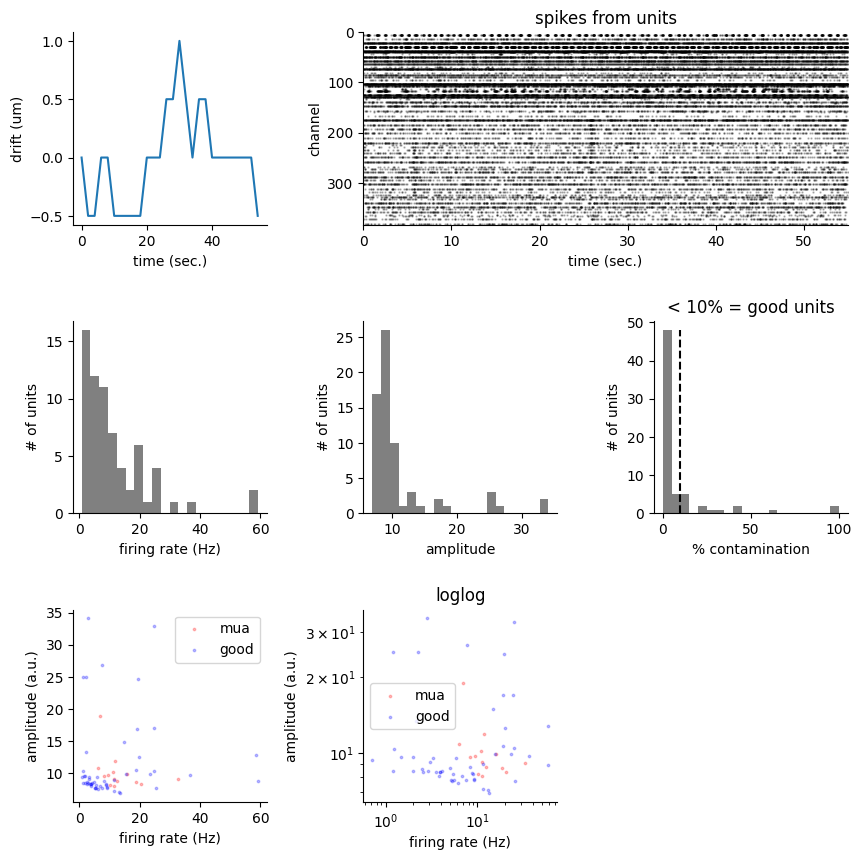

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5 * np.ones(3)

fig = plt.figure(figsize=(10,10), dpi=100)
grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)

ax = fig.add_subplot(grid[0,0])
ax.plot(np.arange(0, ops['Nbatches'])*2, dshift);
ax.set_xlabel('time (sec.)')
ax.set_ylabel('drift (um)')

ax = fig.add_subplot(grid[0,1:])
t0 = 0
t1 = np.nonzero(st > ops['fs']*55)[0][0]
ax.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
ax.set_xlim([0, 55])
ax.set_ylim([chan_map.max(), 0])
ax.set_xlabel('time (sec.)')
ax.set_ylabel('channel')
ax.set_title('spikes from units')

ax = fig.add_subplot(grid[1,0])
nb=ax.hist(firing_rates, 20, color=gray)
ax.set_xlabel('firing rate (Hz)')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,1])
nb=ax.hist(camps, 20, color=gray)
ax.set_xlabel('amplitude')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,2])
nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
ax.plot([10, 10], [0, nb[0].max()], 'k--')
ax.set_xlabel('% contamination')
ax.set_ylabel('# of units')
ax.set_title('< 10% = good units')

for k in range(2):
    ax = fig.add_subplot(grid[2,k])
    is_ref = contam_pct<10.
    ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
    ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_xlabel('firing rate (Hz)')
    ax.legend()
    if k==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('loglog')

In [7]:
from collections import Counter
import pandas as pd

df = pd.DataFrame(
    {"spike_times": st[t0:t1] / 30000.0, "channel": chan_best[clu[t0:t1]]}
)

s = df.sort_values("channel")

c = Counter(s["channel"])

sorted_count = sorted(c.items(), key=lambda i: i[0])

truncated_channel = []
for i in range(len(sorted_count)):
    temp_list = [i] * sorted_count[i][1]
    truncated_channel += temp_list

In [8]:
len(chan_best)

67

In [9]:
assert len(truncated_channel) == len(s)
s["truncated_channel"] = truncated_channel

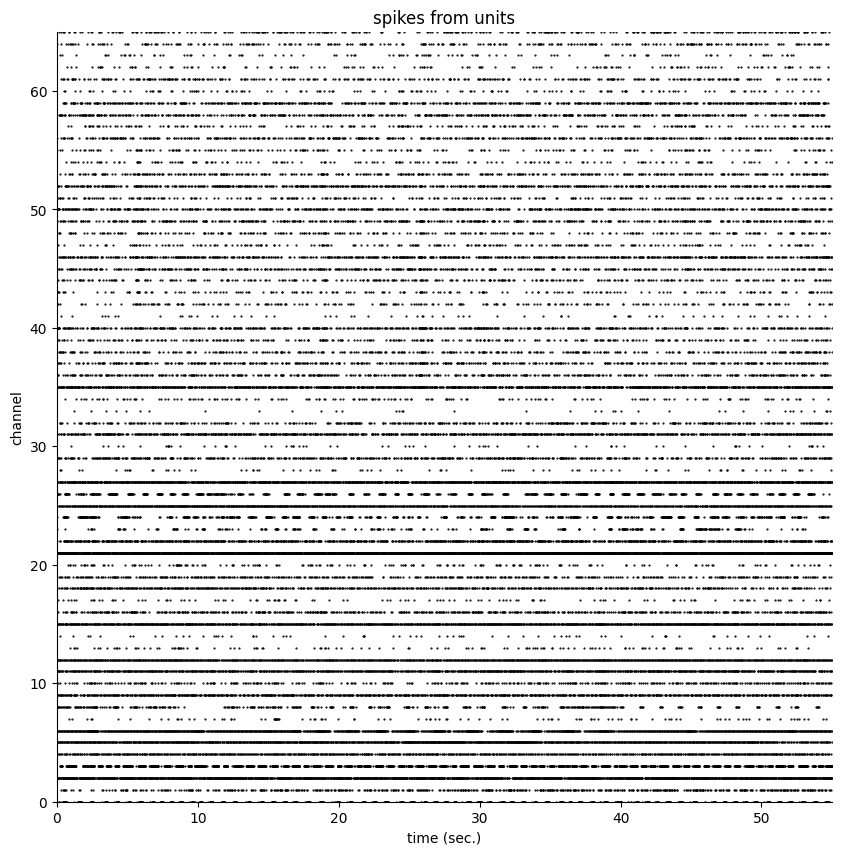

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
t0 = 0
final_time = 55
t1 = np.nonzero(st > ops["fs"] * final_time)[0][0]
# ax.scatter(st[t0:t1] / 30000.0, chan_best[clu[t0:t1]], s=0.5, color="k", alpha=0.25)
ax.scatter(s["spike_times"], s["truncated_channel"], s=0.3, color="k", alpha=1)
ax.set_xlim([0, s["spike_times"].max()])
ax.set_ylim([s["truncated_channel"].max(), 0])
ax.set_ylim([0, s["truncated_channel"].max()])
ax.set_xlabel("time (sec.)")
ax.set_ylabel("channel")
ax.set_title("spikes from units")

plt.savefig(f"{trial_name}_raster.svg", dpi=300, transparent=True)

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


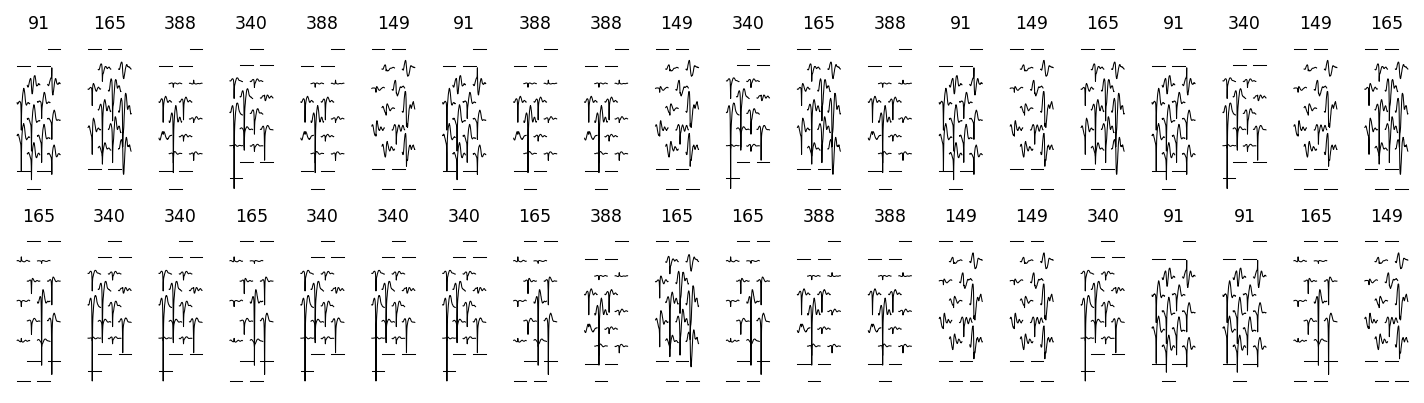

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


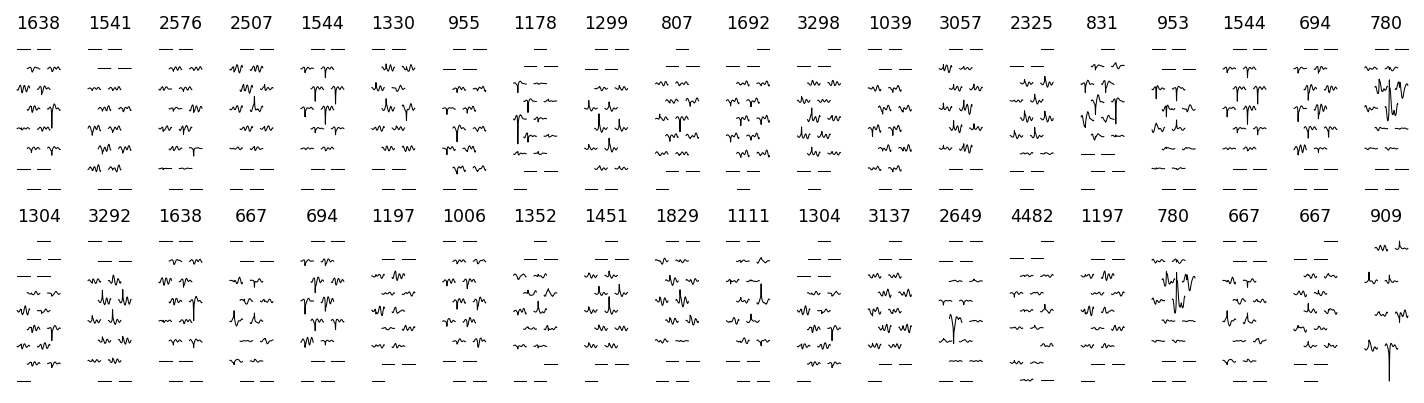

In [28]:
probe = ops["probe"]
# x and y position of probe sites
xc, yc = probe["xc"], probe["yc"]
nc = 16  # number of channels to show
good_units = np.nonzero(contam_pct <= 0.1)[0]
mua_units = np.nonzero(contam_pct > 0.1)[0]


gstr = ["good", "mua"]
for j in range(2):
    print(f"~~~~~~~~~~~~~~ {gstr[j]} units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("title = number of spikes from each unit")
    units = good_units if j == 0 else mua_units
    fig = plt.figure(figsize=(12, 3), dpi=150)
    grid = gridspec.GridSpec(2, 20, figure=fig, hspace=0.25, wspace=0.5)

    for k in range(40):
        wi = units[np.random.randint(len(units))]
        wv = templates[wi].copy()
        cb = chan_best[wi]
        nsp = (clu == wi).sum()

        ax = fig.add_subplot(grid[k // 20, k % 20])
        n_chan = wv.shape[-1]
        ic0 = max(0, cb - nc // 2)
        ic1 = min(n_chan, cb + nc // 2)
        wv = wv[:, ic0:ic1]
        x0, y0 = xc[ic0:ic1], yc[ic0:ic1]

        amp = 4
        for ii, (xi, yi) in enumerate(zip(x0, y0)):
            t = np.arange(-wv.shape[0] // 2, wv.shape[0] // 2, 1, "float32")
            t /= wv.shape[0] / 20
            ax.plot(xi + t, yi + wv[:, ii] * amp, lw=0.5, color="k")

        ax.set_title(f"{nsp}", fontsize="small")
        ax.axis("off")
    plt.show()

In [1]:
import spikeinterface.full as si
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [8]:
base_folder = Path("/home/anirudh/spike_sorting/SGL_DATA/")

spikeglx_folder = base_folder / "test-day1- spine-bellyneuron_g1/"

In [12]:
stream_names, stream_ids = si.get_neo_streams("spikeglx", spikeglx_folder)
stream_names

['imec0.ap', 'nidq', 'imec0.lf']

In [13]:
raw_rec = si.read_spikeglx(spikeglx_folder, stream_name="nidq", load_sync_channel=False)
raw_rec

SpikeGLXRecordingExtractor: 9 channels - 10.6kHz - 1 segments - 591,490 samples - 55.84s 
                            int16 dtype - 10.15 MiB

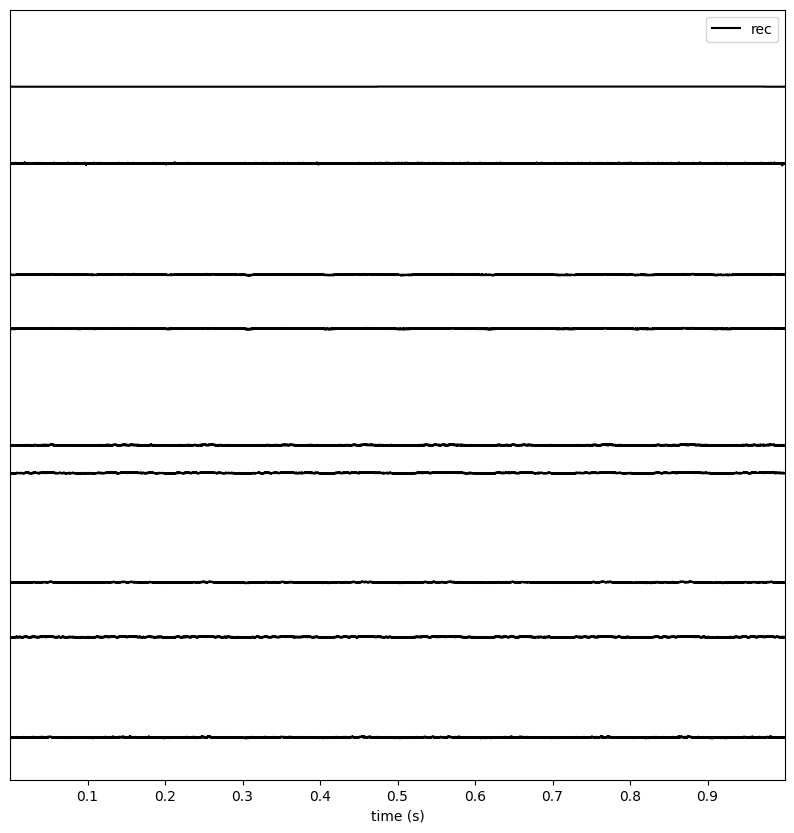

In [15]:
fig, axs = plt.subplots(ncols=1, figsize=(10, 10))

si.plot_traces(raw_rec, backend="matplotlib", clim=(-50, 50), ax=axs)
# si.plot_traces(rec4, backend="matplotlib", clim=(-50, 50), ax=axs[1])
# si.plot_traces(rec, backend="matplotlib", clim=(-50, 50), ax=axs[2])
# for i, label in enumerate(("filter", "cmr", "final")):
#     axs[i].set_title(label)

In [40]:
# rec1 = si.highpass_filter(raw_rec, freq_min=400.0)
# bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)
# rec2 = rec1.remove_channels(bad_channel_ids)
# print("bad_channel_ids", bad_channel_ids)

# rec3 = si.phase_shift(rec2)
# rec4 = si.common_reference(rec3, operator="median", reference="global")
# rec = rec4
# rec